<a href="https://colab.research.google.com/github/falahgs/Classification-Covid-19-X-Ray-Images/blob/master/Classification_Covid_19_X_Ray%C2%A0Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classification Covid 19 X-Ray Images
 Using Transfer learning with EfficientNet and MobileNetV2

In [0]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from google.colab import files
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 66 May 24 07:01 kaggle.json


In [0]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database


100% 1.15G/1.15G [00:20<00:00, 77.4MB/s]
100% 1.15G/1.15G [00:21<00:00, 58.7MB/s]


In [0]:
%%capture
!unzip /content/covid19-radiography-database.zip

In [0]:
!pip install efficientnet

In [0]:
from keras.models import Model,Sequential
from keras.utils import np_utils 
from keras.models import load_model
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report,f1_score
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import ReduceLROnPlateau
import efficientnet.keras as efn 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import seaborn as sns
import numpy as np
import itertools

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [0]:
def model_efficientnetb0(no_classes):
#mport Model
		img_shape=224
		import efficientnet.keras as efn 
		model =efn.EfficientNetB0(weights ='noisy-student', include_top=False, input_shape = (img_shape,img_shape,3))
		model.summary()
		x = model.output
		x = GlobalAveragePooling2D()(x)
		x = Dropout(0.2)(x)
		x = Dense(128, activation="relu")(x)
		x = Dropout(0.2)(x)
		x = Dense(64, activation="relu")(x)
		predictions = Dense(no_classes, activation="softmax")(x)
		model = Model(inputs=model.input, outputs=predictions)
	  model.
	
		return model

In [0]:
def model_efficientnetb7(no_classes):
#mport Model 
		img_shape=600
		model =efn.EfficientNetB7(weights ='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))
		model.summary()
		x = model.output
		x = GlobalAveragePooling2D()(x)
		x = Dropout(0.2)(x)
		x = Dense(128, activation="relu")(x)
		x = Dropout(0.2)(x)
		x = Dense(64, activation="relu")(x)
		predictions = Dense(no_classes, activation="softmax")(x)
		model = Model(inputs=model.input, outputs=predictions)
		return model

In [0]:
def model_mobilnetv2(no_classes):
#mport Model 
		img_shape=224
		model =MobileNetV2(weights ='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))
		model.summary()
		x = model.output
		x = GlobalAveragePooling2D()(x)
		x = Dropout(0.2)(x)
		x = Dense(128, activation="relu")(x)
		x = Dropout(0.2)(x)
		x = Dense(64, activation="relu")(x)
		predictions = Dense(no_classes, activation="softmax")(x)
		model = Model(inputs=model.input, outputs=predictions)
		return model	

In [0]:
#confusion  matrix
def plot_confusion_matrix(test_y, test_predict_y,labels):
        
    C = confusion_matrix(test_y, test_predict_y)        
    A =(((C.T)/(C.sum(axis=1))).T)      
    B =(C/C.sum(axis=0))    
    plt.figure(figsize=(20,5))
    plt.suptitle(" Confusion, Presicion & Recall Matrix", fontsize=24)
   
    #labels = ["COVID-19", "NORMAL", "VIRUAL PENUMONIA"]
    # representing A in heatmap format
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [0]:
def plot_confusion_matrix_normalize(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [0]:
def model_train(dataset_path,model_name,epochs,batch_size,no_class,img_shape):

	no_classes=no_class
	data_gen= ImageDataGenerator(
		 horizontal_flip=True,
		 vertical_flip=True,
		 rotation_range=90,
		 width_shift_range=0.1,
		 height_shift_range=0.1,
		 zoom_range=.1,
		 rescale=1/255,
		 fill_mode='nearest',
		 shear_range=0.1,
		 brightness_range=[0.5, 1.5],
		 validation_split=0.3)

	#load the training data
	train_generator = data_gen.flow_from_directory(
		 dataset_path,
		 target_size=(img_shape,img_shape),
		 batch_size=batch_size,
		 class_mode='categorical',
		 subset='training',
		 shuffle=True)
	 #load the training data
	val_suffle=False
	val_generator = data_gen.flow_from_directory(
		 dataset_path,
		 target_size=(img_shape,img_shape),
		 batch_size=batch_size,
		 class_mode='categorical',
		 subset='validation',shuffle=val_suffle)
	
	train_generator.next()[0].shape,train_generator.next()[1].shape
	val_generator.next()[0].shape,val_generator.next()[1].shape
	x,y = train_generator.next()
	plt.figure(figsize=(10,10))
	for i in range(8):
		#print(i)
		plt.subplot(4,2,i+1)
		image = x[i]
		label = y[i]
		print (label)
		plt.imshow(image)
	plt.show()
	if model_name=='efficientnetb0':
		model=model_efficientnetb0(no_classes)
	if model_name=='efficientnetb7':
		model=model_efficientnetb7(no_classes)
	if model_name=='mobilenetv2':
		model=model_mobilnetv2(no_classes)	
	model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
	model.summary()
	results = model.fit(train_generator,epochs=epochs,steps_per_epoch=train_generator.n/batch_size,
							validation_data=val_generator,validation_steps=val_generator.n/batch_size,
							callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])
	return results,val_generator,model,train_generator

In [0]:
dataset_path='/content/COVID-19 Radiography Database'
model_name='efficientnetb0'
epochs=10
batch_size=48
no_class=3
img_shape=224

Found 2035 images belonging to 3 classes.
Found 870 images belonging to 3 classes.
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]


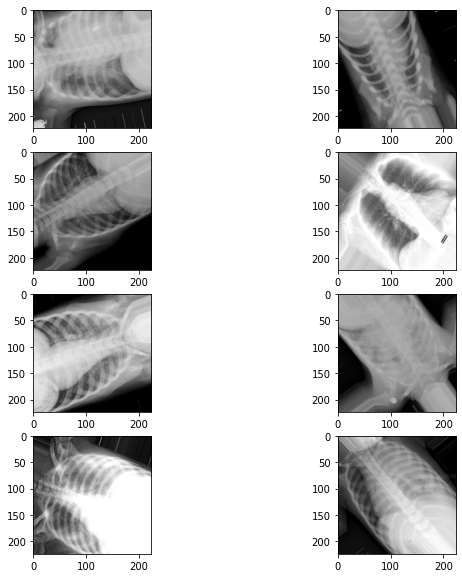

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [0]:
results,val_generator,model,train_generator=model_train(dataset_path,model_name,epochs,batch_size,no_class,img_shape)

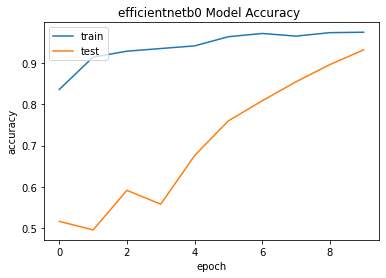

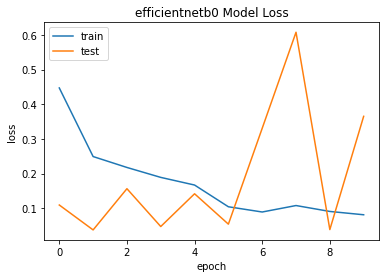

<Figure size 432x288 with 0 Axes>

In [0]:
#display training and validation accurecy and  loss rate for both 
no_epochs=int(epochs)
#print(results.history['accuracy'])
#print(results.history['val_accuracy'])
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title(model_name+' Model Accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(model_name+'_accuracy.png')
plt.show()
plt.savefig(model_name+'_accuracy.png')
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title(model_name+' Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(model_name+'_loss.png')
plt.show()
plt.savefig(model_name+'_loss.png')

In [0]:
#display accurecy score and f1_score 
val_generator.reset()
pred=model.predict_generator(val_generator,steps=val_generator.n/batch_size,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
y_pred=model.predict(val_generator,steps=val_generator.n/batch_size,verbose=1)
y_true = val_generator.classes
y_pred=np.argmax(y_pred, axis=1)
print('accuracy_score:',accuracy_score(y_true,y_pred))
print('f1_score:',f1_score(y_true,y_pred,average='macro'))

19/18 [===============================] - 29s 2s/step
accuracy_score: 0.9218390804597701
f1_score: 0.8925083745644264


In [0]:
#report classifcation for all model metrics
class_label=list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))
class_names = val_generator.class_indices.keys()

                 precision    recall  f1-score   support

       COVID-19       0.68      1.00      0.81        65
         NORMAL       0.97      0.87      0.92       402
Viral Pneumonia       0.93      0.96      0.94       403

       accuracy                           0.92       870
      macro avg       0.86      0.94      0.89       870
   weighted avg       0.93      0.92      0.92       870



Train Confusion Matrix


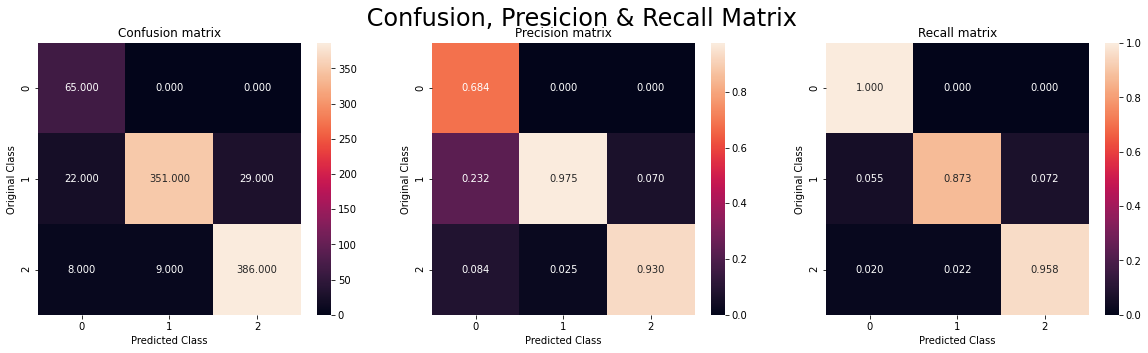

In [0]:
# Confusion Matrix for metrics (Cnfusion,Presicion,Recall Matrix)
print('Train Confusion Matrix')
plot_confusion_matrix(y_true,y_pred,labels)

Normalize Confusion Matrix 


<Figure size 432x288 with 0 Axes>

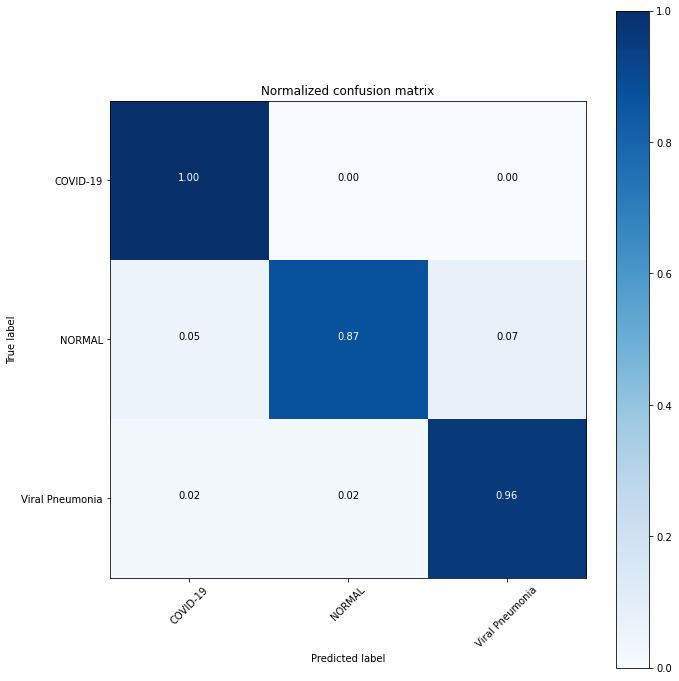

In [0]:
print('Normalize Confusion Matrix ')
  # compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix_normalize(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [0]:
#save model
model.save(model_name+'.h5')

In [0]:
#test another predicition
from keras.preprocessing.image import load_img
model_path='/content/efficientnetb0.h5'
img_path='/content/unseen_dataset/1.png'
model=load_model(model_path)
img =load_img(img_path, target_size=(img_shape,img_shape))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x /= 255.
result = model.predict([x])
print(result)
confidence = result.max() * 100
print('The Confidence is:',confidence)
labels=("COVID-19", "NORMAL", "VIRUAL PENUMONIA")
preds = result.argmax(axis=1)[0]
result_out = labels[preds]
print('The Class Name is:',result_out)
predicted_class_indices=np.argmax(result,axis=1)


[[1.79e-06 9.87e-01 1.25e-02]]
The Confidence is: 98.7497091293335
The Class Name is: NORMAL


#using another model  for MobileNetV2

In [0]:
#unsing another model  for MobileNetV2
dataset_path='/content/COVID-19 Radiography Database'
model_name='mobilenetv2'
epochs=25
batch_size=16
no_class=3
img_shape=224

Found 2035 images belonging to 3 classes.
Found 870 images belonging to 3 classes.
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]


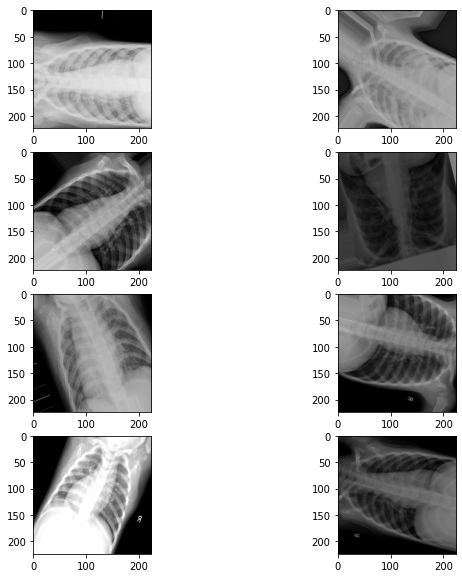

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
results,val_generator,model,train_generator=model_train(dataset_path,model_name,epochs,batch_size,no_class,img_shape)

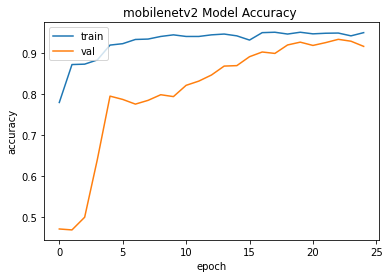

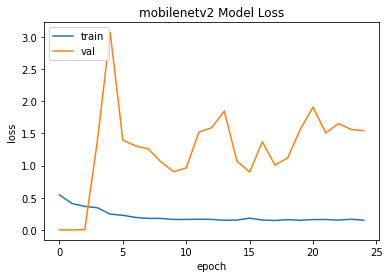

<Figure size 432x288 with 0 Axes>

In [0]:
#display training and validation figuers accurecy and  loss rate for both 
no_epochs=int(epochs)
#print(results.history['accuracy'])
#print(results.history['val_accuracy'])
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title(model_name+' Model Accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(model_name+'_accuracy.png')
plt.show()
plt.savefig(model_name+'_accuracy.png')
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title(model_name+' Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(model_name+'_loss.png')
plt.show()
plt.savefig(model_name+'_loss.png')

In [0]:
#display accurecy score and f1_score 
val_generator.reset()
pred=model.predict_generator(val_generator,steps=val_generator.n/batch_size,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
y_pred=model.predict(val_generator,steps=val_generator.n/batch_size,verbose=1)
y_true = val_generator.classes
y_pred=np.argmax(y_pred, axis=1)
print('accuracy_score:',accuracy_score(y_true,y_pred))
print('f1_score:',f1_score(y_true,y_pred,average='macro'))

55/54 [==============================] - 29s 520ms/step
accuracy_score: 0.9206896551724137
f1_score: 0.9143100292622024


In [0]:
#report classifcation for all model metrics
class_label=list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))
class_names = val_generator.class_indices.keys()

                 precision    recall  f1-score   support

       COVID-19       1.00      0.82      0.90        65
         NORMAL       0.91      0.94      0.92       402
Viral Pneumonia       0.92      0.92      0.92       403

       accuracy                           0.92       870
      macro avg       0.94      0.89      0.91       870
   weighted avg       0.92      0.92      0.92       870



Train Confusion Matrix


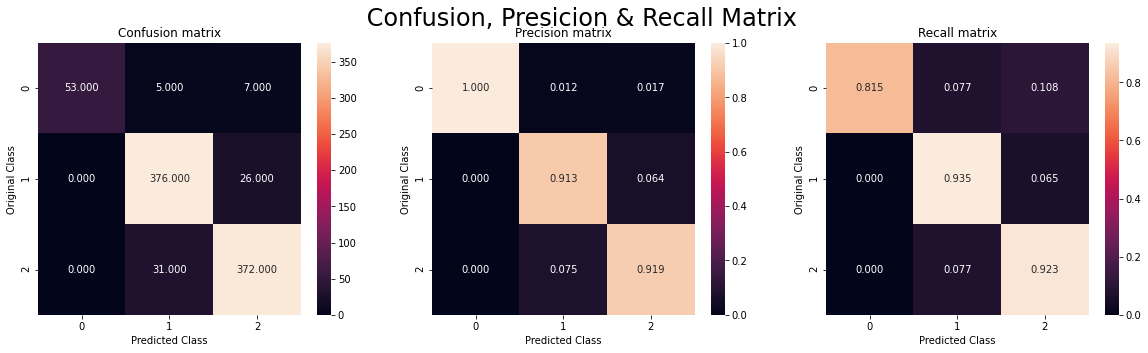

In [0]:
# Confusion Matrix for metrics (Cnfusion,Presicion,Recall Matrix)
print('Train Confusion Matrix')
plot_confusion_matrix(y_true,y_pred,labels)

Normalize Confusion Matrix 


<Figure size 432x288 with 0 Axes>

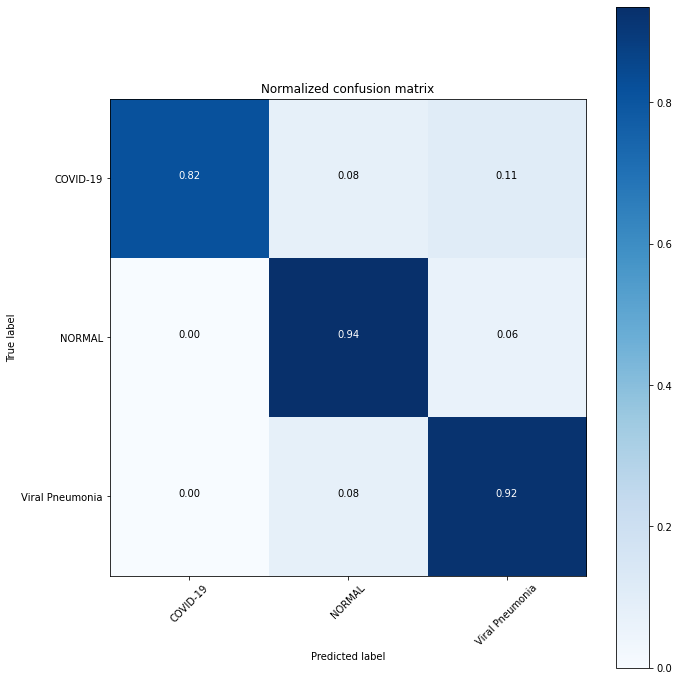

In [0]:
print('Normalize Confusion Matrix ')
  # compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix_normalize(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [0]:
#save model
model.save(model_name+'.h5')

In [0]:
#test another predicition
from keras.preprocessing.image import load_img
model_path='/content/mobilenetv2.h5'
img_path='/content/unseen_dataset/1.png'
model=load_model(model_path)
img =load_img(img_path, target_size=(img_shape,img_shape))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x /= 255.
result = model.predict([x])
print(result)
confidence = result.max() * 100
print('The Confidence is:',confidence)
labels=("COVID-19", "NORMAL", "VIRUAL PENUMONIA")
preds = result.argmax(axis=1)[0]
result_out = labels[preds]
print('The Class Name is:',result_out)
predicted_class_indices=np.argmax(result,axis=1)


[[9.99e-01 4.12e-04 4.65e-04]]
The Confidence is: 99.91230368614197
The Class Name is: COVID-19


In [0]:
img_path='/content/unseen_dataset/2.png'
img =load_img(img_path, target_size=(img_shape,img_shape))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x /= 255.
result = model.predict([x])
print(result)
confidence = result.max() * 100
print('The Confidence is:',confidence)
labels=("COVID-19", "NORMAL", "VIRUAL PENUMONIA")
preds = result.argmax(axis=1)[0]
result_out = labels[preds]
print('The Class Name is:',result_out)
predicted_class_indices=np.argmax(result,axis=1)

[[3.62e-06 9.96e-01 4.33e-03]]
The Confidence is: 99.56690073013306
The Class Name is: NORMAL


In [0]:
#report classifcation for all model metrics
class_label=list(val_generator.class_indices.keys())
#print(classification_report(y_true, y_pred,target_names=class_label))
class_names = val_generator.class_indices.keys()
class_names

dict_keys(['COVID-19', 'NORMAL', 'Viral Pneumonia'])

In [0]:
class_label

['COVID-19', 'NORMAL', 'Viral Pneumonia']

In [0]:
# get a random batch of images
#import matplotlib.pyplot as plt
class_names = val_generator.class_indices.keys()
class_names


dict_keys(['COVID-19', 'NORMAL', 'Viral Pneumonia'])

In [0]:
image_batch, label_batch = next(iter(val_generator)) = next(iter(val_generator))


In [0]:
image_batch, label_batch = next(iter(val_generator))
# turn the original labels into human-readable text
label_batch = [class_label[np.argmax(label_batch[i])] for i in range(batch_size)]

['NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL'
 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL']


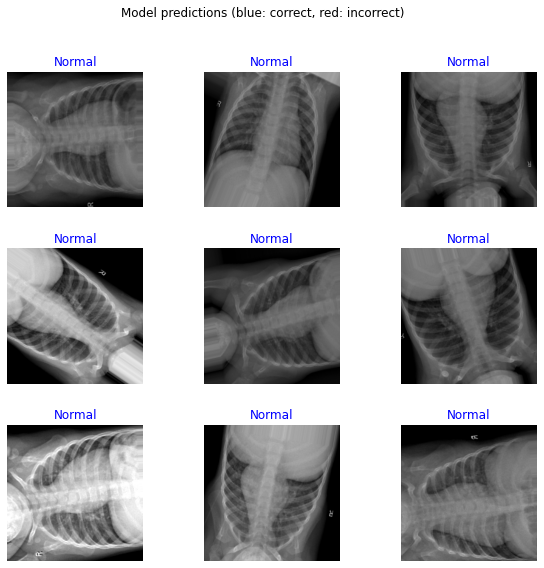

In [0]:
# get a random batch of images
#import matplotlib.pyplot as plt
class_names = val_generator.class_indices.keys()
image_batch, label_batch = next(iter(val_generator))
# turn the original labels into human-readable text
label_batch = [class_label[np.argmax(label_batch[i])] for i in range(batch_size)]
# predict the images on the model
predicted_class_names = model.predict(image_batch)
predicted_ids = [np.argmax(predicted_class_names[i]) for i in range(batch_size)]
# turn the predicted vectors to human readable labels
predicted_class_names = np.array([class_label[id] for id in predicted_ids])
print(predicted_class_names)
# some nice plotting
plt.figure(figsize=(10,9))
for n in range(9):
    plt.subplot(3,3,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    if predicted_class_names[n] == label_batch[n]:
        color = "blue"
        title = predicted_class_names[n].title()
    else:
        color = "red"
        title = f"{predicted_class_names[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
plt.show()